---
title: Comparing EpigenomeXcan and Enformer gene expression prediction performance 
author: Sabrina Mi
date: 1/10/2024
---

**Takeaways**

* I definitely need to parallelize if we want to test across 340 samples
    * 1 gene, 340 samples: ~ 30 seconds
    * 114 genes, 272 samples: ~ 55 minutes
* Lots of bumps trying to implement parsl
* Genes with more significantly correlated Enformer predictions tended to have significantly correlated EpigenomeXcan predictions, although not necessarily in the same direction

## Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
import os
import time
columns = ['POS', 'ACI', 'BN', 'BUF', 'F344', 'M520', 'MR', 'WKY', 'WN']

2024-01-18 06:58:38.584477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 06:58:44.538569: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /soft/compilers/cudatoolkit/cuda-11.8.0/extras/CUPTI/lib64:/soft/compilers/cudatoolkit/cuda-11.8.0/lib64:/soft/libraries/trt/TensorRT-8.5.2.2.Linux.x86_64-gnu.cuda-11.8.cudnn8.6/lib:/soft/libraries/nccl/nccl_2.16.2-1+cuda11.8_x86_64/lib:/soft/libraries/cudnn/cudnn-11-linux-x64-v8.6.0.163/lib:/opt/cray/pe/gcc/11.2.0/snos/lib64:/opt/cray/pe/papi/6.0.0.14/lib64:/opt/cray/libfabric/1.11.0.4.125/lib64:/

In [2]:
pred_expr = pd.read_csv("/home/s1mi/enformer_rat_data/output/Br_human_predicted_expression.csv", index_col=0)
individuals = list(pred_expr.index)
gene_annot = pd.read_csv("/eagle/AIHPC4Edu/sabrina/Br_predictions/HS_founder_epigenomes/gene_mapping.txt")
genes_df = gene_annot[gene_annot['gene'].isin(pred_expr.columns)]

In [3]:
probabilities_dir = "/home/s1mi/Br_genotype_probabilities"
reference_dir = "/eagle/AIHPC4Edu/sabrina/Br_predictions/HS_founder_epigenomes/human"
output_dir = "/eagle/AIHPC4Edu/sabrina/Br_prediction_from_founders"
run_dir = "/home/s1mi/Github/deep-learning-in-genomics/posts/2024-01-10-epigenomexcan-vs-enformer-significant-genes"

In [4]:
def interpolate(x, xi, y):
    j   =   tf.argsort(tf.concat((x, xi), axis=-1))
    k   =   tf.range(len(j))
    q   =   tf.scatter_nd(j[:, tf.newaxis], k, k.shape)

    lxi =   len(xi)

    r   =   q[-lxi:]-tf.range(0, lxi)
    r   =   tf.where(xi == x[-1], q[-1:] - lxi, r)

    x2  =   tf.gather(x, r)
    x1  =   tf.gather(x, r-1)
    y2  =   tf.gather(y, r)
    y1  =   tf.gather(y, r-1)

    u   =   (xi-x1)/(x2-x1)
    if not tf.rank(u) == tf.rank(y1):
        u   =   tf.expand_dims(u, axis=-1)

    yi  =   (1.0-u)*y1 + u*y2

    return tf.where(y1 == y2, y1, yi)

def compute_epigenome(reference_file, gene, start, end, prob):
    x = tf.constant(prob['POS'].values)
    y = tf.constant(prob.drop(columns=['POS']).values)
    bins = tf.linspace(start, end, 896)
    pr_tensor = tf.expand_dims(tf.cast(interpolate(x, bins, y), dtype=tf.float32), axis=1)
    with h5py.File(reference_file, "r") as hf:
        matrix = hf[gene][:]
    ref_tensor = tf.transpose(matrix, perm=[1, 0, 2])
    # pr_tensor = tf.cast(pr_tensor, dtype=tf.float16)
    # ref_tensor = tf.cast(ref_tensor, dtype=tf.float16)
    output = tf.squeeze(tf.matmul(pr_tensor, ref_tensor), axis=1)
    return output

def run_sample_predictions(prob, reference_file, gene_annot):
    predictions = []
    for index, row in gene_annot.iterrows():
        gene = row['gene']
        tss = row['tss']
        start = tss - 57344
        end = tss + 57344
        if (start >= prob.iloc[0,0] and end <= prob.iloc[-1,0]):
            output = compute_epigenome(reference_file, gene, start, end, prob)
            # Process genotype probabilities
            predictions.append(np.average(output[446:450]))
    return predictions

In [ ]:
for chr, group in genes_df.groupby("chromosome"):
    start_time = time.perf_counter()
    reference_file = os.path.join(reference_dir, f"{chr}_genes.h5")
    probabilities_file = os.path.join(probabilities_dir, f"{chr}_probabilities.h5")
    output_file = os.path.join(output_dir, f"{chr}_selected_genes.csv")
    haplo_expr = pd.DataFrame(columns=group['gene'], index=pred_expr.index)
    if os.path.exists(output_file):
        continue
    with h5py.File(os.path.join(probabilities_dir, f"{chr}_probabilities.h5"), "r") as input:
        for individual in haplo_expr.index:
            prob = pd.DataFrame(input[individual][:], columns=columns)
            predictions = run_sample_predictions(prob, reference_file, group)
            haplo_expr.loc[individual] = predictions
            # print(individual, "...", toc - tic, "sec")
    end_time = time.perf_counter()
    print(f"{chr}:", start_time - end_time, "seconds")
    haplo_expr.to_csv(output_file)

## Sampling Genes for Evaluation

In [3]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
colors = sns.color_palette("pastel")

In [5]:
output_dir = "/eagle/AIHPC4Edu/sabrina/Br_prediction_from_founders"
output = pd.read_csv(os.path.join(output_dir, "chr1_selected_genes.csv"), index_col=0).dropna()
obs_expr = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed", sep="\t", header=0, index_col='gene_id')
cors = pd.read_csv("/home/s1mi/enformer_rat_data/output/Br_personalized_spearman_corr_human.csv", index_col = 0)

/tmp/ipykernel_126730/2310328556.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  obs_expr = pd.read_csv("/home/s1mi/enformer_rat_data/expression_data/Brain.rn7.expr.tpm.bed", sep="\t", header=0, index_col='gene_id')


In [6]:
## subset obs
gene_list = output.columns.intersection(cors.index)
samples = output.index
cors = cors.loc[gene_list]
obs_expr = obs_expr.loc[gene_list, samples]


In [7]:
output_cors = pd.DataFrame(columns = ["r", "pval"], index = gene_list)
for gene in gene_list:
    corr, pval = stats.spearmanr(obs_expr.loc[gene].values, output[gene])
    output_cors.loc[gene] = [corr, pval]

### Distribution of Spearman R, P-value

To plot the performance of gene expression derived from the EpigenomeXcan method (haplotype probabilities $$x$$ founder epigenomes) compared to ground truth. 

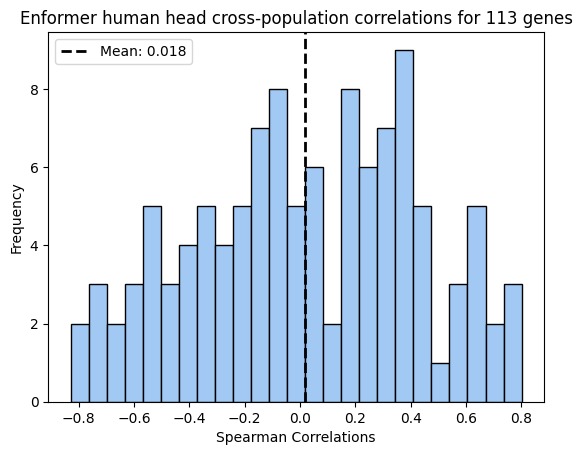

In [50]:
# Plot a pearson_corr_by_gene["human"]histogram
plt.hist(output_cors["r"], bins=25, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title('EpigenomeXcan correlations (across n = 272) for 113 genes')
plt.xlabel('Spearman Correlations')
plt.ylabel('Frequency')
mean = np.mean(output_cors["r"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()

# Display the plot
plt.show()

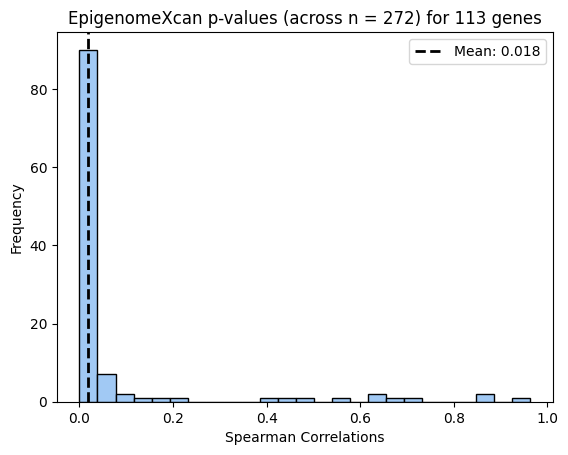

In [10]:
# Plot a pearson_corr_by_gene["human"]histogram
plt.hist(output_cors["pval"], bins=25, edgecolor='black', color=colors[0])  # 'bins' determines the number of bins or bars
plt.title('EpigenomeXcan p-values (across n = 272) for 113 genes')
plt.xlabel('Spearman Correlations')
plt.ylabel('Frequency')
mean = np.mean(output_cors["r"])
plt.axvline(mean, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
plt.legend()

# Display the plot
plt.show()

### Comparing Methods: Enformer vs EpigenomeXcan

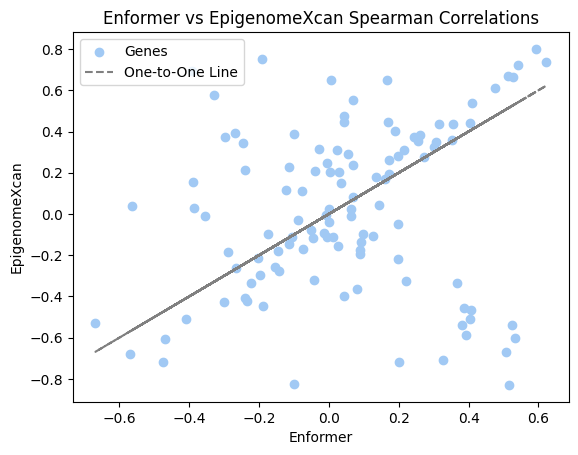

In [11]:
# Fit a linear regression line to the data (calculate slope)
x = cors["spearman r"].values.astype(np.float32)
y = output_cors["r"].values.astype(np.float32)
#  slope, intercept = np.polyfit(x, y, 1)
# Create the plot
plt.scatter(x, y, label='Genes', marker='o', color=colors[0])
# plt.plot(x, slope * x + intercept, '--', color="black", label=f'Best Fit Line: y = {slope:.3f}x + {intercept:.3f}')
plt.plot(x, x, '--', color="grey", label=f'One-to-One Line')
plt.title("Enformer vs EpigenomeXcan Spearman Correlations")
# Add labels and legend
plt.xlabel('Enformer')
plt.ylabel('EpigenomeXcan')
plt.legend()

# Show the plot
plt.show()

In [19]:
#| code-fold: true
def qqR(corvec, nn, title):
    # nn is the sample size, the number of individuals used to compute correlation
    # corvec is the correlation vector

    mm = len(corvec)
    nullcorvec = np.tanh(np.random.normal(size=mm) / np.sqrt(nn - 3))  # null correlation vector

    sm.qqplot_2samples(nullcorvec, corvec)
    plt.plot([0, 1], [0, 1], color='grey')  # Diagonal line
    plt.title(title)
    plt.grid()
    plt.show()

## Parsl Test

In [2]:
import parsl
from parsl.configs.htex_local import config
from parsl import python_app

parsl.load(config)

In [3]:
def interpolate(x, xi, y):
    j   =   tf.argsort(tf.concat((x, xi), axis=-1))
    k   =   tf.range(len(j))
    q   =   tf.scatter_nd(j[:, tf.newaxis], k, k.shape)

    lxi =   len(xi)

    r   =   q[-lxi:]-tf.range(0, lxi)
    r   =   tf.where(xi == x[-1], q[-1:] - lxi, r)

    x2  =   tf.gather(x, r)
    x1  =   tf.gather(x, r-1)
    y2  =   tf.gather(y, r)
    y1  =   tf.gather(y, r-1)

    u   =   (xi-x1)/(x2-x1)
    if not tf.rank(u) == tf.rank(y1):
        u   =   tf.expand_dims(u, axis=-1)

    yi  =   (1.0-u)*y1 + u*y2

    return tf.where(y1 == y2, y1, yi)

def compute_epigenome(reference_file, gene, start, end, prob):
    x = tf.constant(prob['POS'].values)
    y = tf.constant(prob.drop(columns=['POS']).values)
    bins = tf.linspace(start, end, 896)
    pr_tensor = tf.expand_dims(interpolate(x, bins, y), axis=1)
    with h5py.File(reference_file, "r") as hf:
        matrix = hf[gene][:]
    ref_tensor = tf.transpose(matrix, perm=[1, 0, 2])
    pr_tensor = tf.cast(pr_tensor, dtype=tf.float16)
    ref_tensor = tf.cast(ref_tensor, dtype=tf.float16)
    output = tf.squeeze(tf.matmul(pr_tensor, ref_tensor), axis=1)
    return output

def run_sample_predictions(prob, reference_file, gene_annot):
    predictions = []
    for index, row in gene_annot.iterrows():
        gene = row['gene']
        tss = row['tss']
        start = tss - 57344
        end = tss + 57344
        if (start >= prob.iloc[0,0] and end <= prob.iloc[-1,0]):
            output = compute_epigenome(reference_file, gene, start, end, prob)
            # Process genotype probabilities
            predictions.append(np.average(output[446:450]))
    return predictions

In [6]:

@python_app
def run_predictions(probabilities_file, reference_file, group, individuals, output_file, log_file, module_path = run_dir):
    import time
    import h5py
    import pandas as pd

    import sys
    sys.path.append(module_path)
    from tensor_helpers import run_sample_predictions
    
    start_time = time.perf_counter()
    haplo_expr = pd.DataFrame(columns=group['gene'], index=individuals)
    f = open(log_file, "w")
    with h5py.File(probabilities_file, "r") as input:
        for individual in individuals:
            tic = time.perf_counter()
            columns = ['POS', 'ACI', 'BN', 'BUF', 'F344', 'M520', 'MR', 'WKY', 'WN']
            prob = pd.DataFrame(input[individual][:], columns=columns)
            predictions = run_sample_predictions(prob, reference_file, group)
            haplo_expr.loc[individual] = predictions
            toc = time.perf_counter()
            f.write(individual, "...", toc - tic, "sec\n")
    end_time = time.perf_counter()
    haplo_expr.to_csv(output_file)
    f.write('Completed job in', (end_time - start_time) / 60 ,'minutes.')
    f.close()
    return haplo_expr

In [9]:
app_futures = []
for chr, group in genes_df.groupby("chromosome"):
    reference_file = os.path.join(reference_dir, f"{chr}_genes.h5")
    probabilities_file = os.path.join(probabilities_dir, f"{chr}_probabilities.h5")
    output_file = os.path.join(output_dir, f"{chr}_selected_genes.csv")
    log_file = os.path.join(output_dir, f"{chr}_selected_genes.log")
    app_futures.append(run_predictions(probabilities_file, reference_file, group, individuals, output_file, log_file, module_path = run_dir))

exec_futures = [q.result() for q in app_futures]

In [10]:
reference_file = os.path.join(reference_dir, f"{chr}_genes.h5")
probabilities_file = os.path.join(probabilities_dir, f"{chr}_probabilities.h5")
individuals = pred_expr.index

In [23]:
import tensorflow as tf
def interpolate(x, xi, y):
    j   =   tf.argsort(tf.concat((x, xi), axis=-1))
    k   =   tf.range(len(j))
    q   =   tf.scatter_nd(j[:, tf.newaxis], k, k.shape)

    lxi =   len(xi)

    r   =   q[-lxi:]-tf.range(0, lxi)
    r   =   tf.where(xi == x[-1], q[-1:] - lxi, r)

    x2  =   tf.gather(x, r)
    x1  =   tf.gather(x, r-1)
    y2  =   tf.gather(y, r)
    y1  =   tf.gather(y, r-1)

    u   =   (xi-x1)/(x2-x1)
    if not tf.rank(u) == tf.rank(y1):
        u   =   tf.expand_dims(u, axis=-1)

    yi  =   (1.0-u)*y1 + u*y2

    return tf.where(y1 == y2, y1, yi)

def compute_epigenome(reference_file, gene, start, end, prob):
    x = tf.constant(prob['POS'].values)
    y = tf.constant(prob.drop(columns=['POS']).values)
    bins = tf.linspace(start, end, 896)
    pr_tensor = tf.expand_dims(tf.cast(interpolate(x, bins, y), dtype=tf.float32), axis=1)
    with h5py.File(reference_file, "r") as hf:
        matrix = hf[gene][:]
    ref_tensor = tf.transpose(matrix, perm=[1, 0, 2])
    output = tf.squeeze(tf.matmul(pr_tensor, ref_tensor), axis=1)
    return output

def run_sample_predictions(prob, reference_file, gene_annot):
    predictions = []
    for index, row in gene_annot.iterrows():
        gene = row['gene']
        tss = row['tss']
        start = tss - 57344
        end = tss + 57344
        if (start >= prob.iloc[0,0] and end <= prob.iloc[-1,0]):
            output = compute_epigenome(reference_file, gene, start, end, prob)
            # Process genotype probabilities
            predictions.append(np.average(output[446:450]))
    return predictions

In [25]:
haplo_expr = pd.DataFrame(columns=group['gene'], index=individuals)
with h5py.File(probabilities_file, "r") as input:
    for individual in individuals:
        tic = time.perf_counter()
        columns = ['POS', 'ACI', 'BN', 'BUF', 'F344', 'M520', 'MR', 'WKY', 'WN']
        prob = pd.DataFrame(input[individual][:], columns=columns)
        predictions = run_sample_predictions(prob, reference_file, group)
        haplo_expr.loc[individual] = predictions
        toc = time.perf_counter()
        print(individual, "...", toc - tic, "sec")
        break

000789972A ... 13.396942946012132 sec
